In [29]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers, models, losses
from PIL import Image
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

class CustomDataGen(keras.utils.Sequence):
    def __init__(self, data_folder: str, aug_len: dict[str, float], batch_size=32, split="train", train_ratio=0.8, seed=42):
        super().__init__()

        self.data_folder = data_folder
        self.aug_len = aug_len
        self.batch_size = batch_size
        self.data = []

        self.pipeline = tf.keras.Sequential([
            keras.layers.RandomFlip("horizontal_and_vertical"),
            keras.layers.RandomRotation(0.2),
            keras.layers.RandomZoom(0.1),
            keras.layers.RandomContrast(0.01),
            keras.layers.Rescaling(1./255),
            keras.layers.Resizing(224, 224),
            keras.layers.Normalization(
                mean=(0.485, 0.456, 0.406), 
                variance=(0.229, 0.224, 0.225)
            )
        ])

        self.split = split
        self.train_ratio = train_ratio
        self.seed = seed
        self.load_data()
        self.classes = {label: idx for idx, label in enumerate(set([item["label"] for item in self.data]))}

    
    def load_data(self):

        all_files = []
        for root, _, files in os.walk(self.data_folder):
            ext = os.path.splitext(files[0])[1]
            if ext not in [".jpg", ".jpeg", ".png"]:
                continue
            subfolder = os.path.basename(root)
            for file in files:
                all_files.append({
                    "path": os.path.join(root, file),
                    "label": subfolder
                })

        random.seed(self.seed)
        random.shuffle(all_files)
        

        split_idx = int(len(all_files) * self.train_ratio)
        

        if self.split == "train":
            base_files = all_files[:split_idx]
        else:
            base_files = all_files[split_idx:]
        

        self.data = []
        for file in base_files:
            if self.split == "train" and file["label"] in self.aug_len:
                prob = self.aug_len[file["label"]]
                for _ in range(int(prob)):
                    self.data.append(file)
                if np.random.rand() < (prob - int(prob)):
                    self.data.append(file)
            else:
                self.data.append(file)
        
        random.shuffle(self.data)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []
        for item in batch_data:
            img = Image.open(item["path"])
            img = np.array(img)
            if img.ndim == 2:
                img = np.stack((img,) * 3, axis=-1)
            elif img.shape[2] == 1:
                img = np.concatenate([img] * 3, axis=-1)
            img = self.pipeline(img)
            batch_images.append(img)
            batch_labels.append(self.classes[item["label"]])

        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        random.shuffle(self.data)

In [30]:
train = CustomDataGen("/home/shared/Mammiferes_jpg", {"cat": 1.5, "dog": 1.5}, batch_size=8, split="train")
test = CustomDataGen("/home/shared/Mammiferes_jpg", {"cat": 1.5, "dog": 1.5}, batch_size=8, split="test")

In [31]:
print(len(train.classes))

13


In [32]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(13, activation='softmax')
])

In [33]:
print(next(iter(train))[0].shape)

(8, 224, 224, 3)


In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses.sparse_categorical_crossentropy,
)

In [35]:
history = model.fit(
    train,
    validation_data=test,
    epochs=20,
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - loss: 2.7501 - val_loss: 2.6481
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 2.4917 - val_loss: 2.6501
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - loss: 2.3634 - val_loss: 2.7184
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - loss: 2.3880 - val_loss: 2.7049
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - loss: 2.2902 - val_loss: 2.9001
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - loss: 2.3443 - val_loss: 2.8623
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 2.2393 - val_loss: 2.8328
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - loss: 2.2561 - val_loss: 2.9328
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - loss: 2.1825 - val_loss: 2.8255
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - loss: 2.1781 - val_loss: 3.0772
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - loss: 2.0880 - val_loss: 3.1650
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step

/tmp/ipykernel_332512/878362657.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


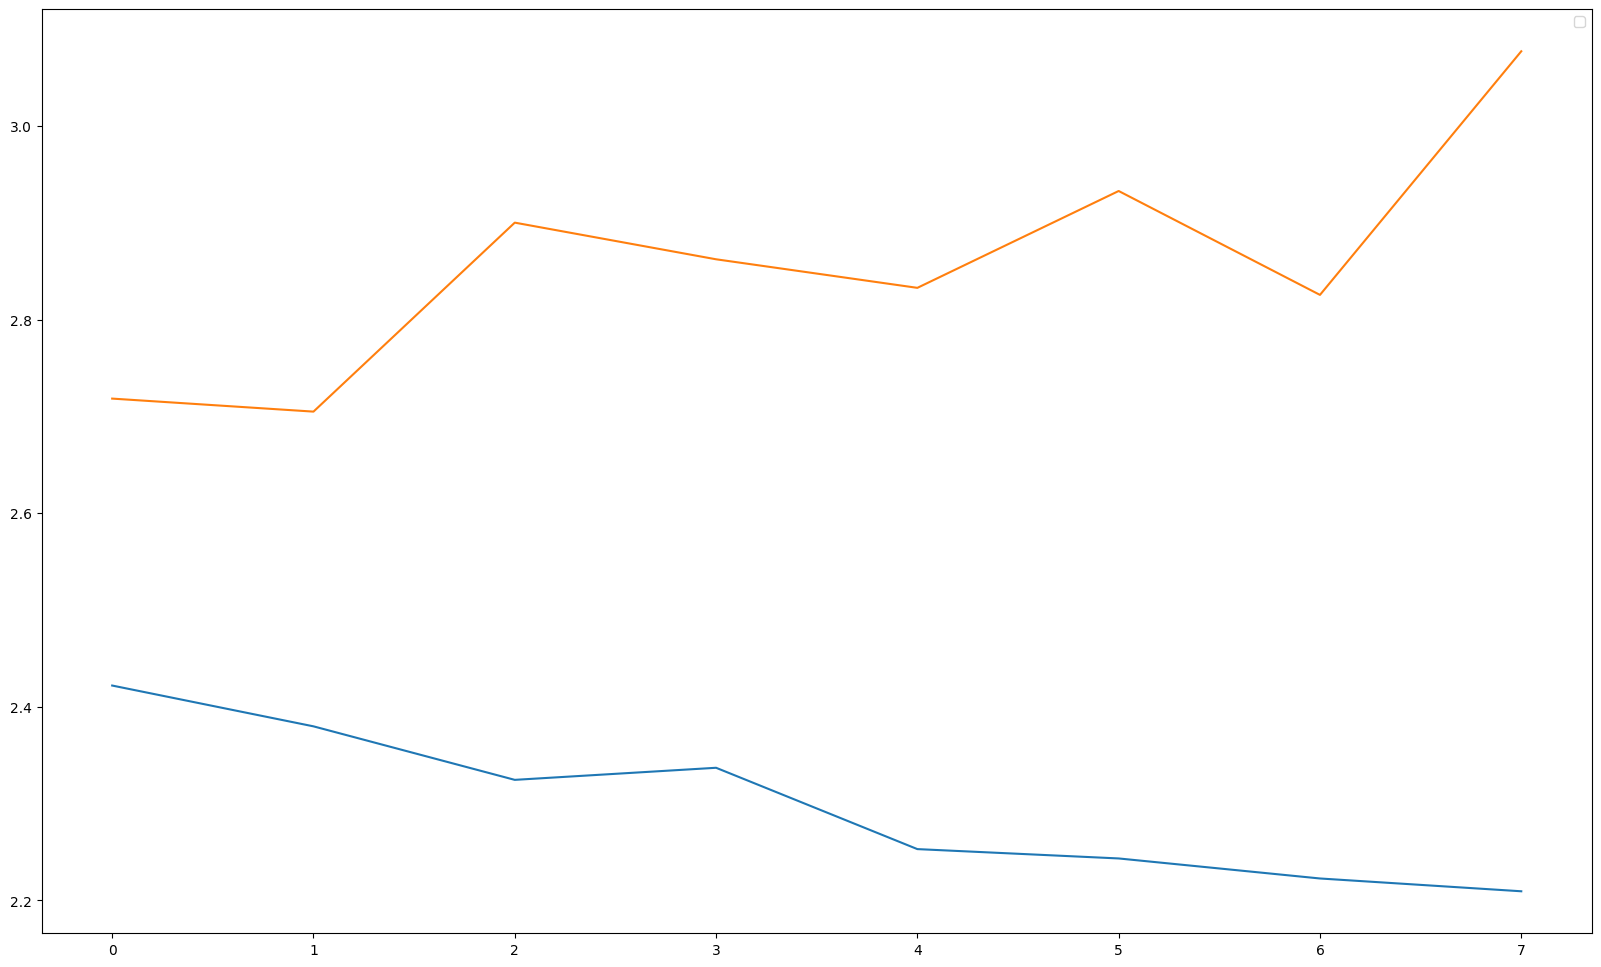

In [36]:
plt.figure(figsize=(20,12))
plt.plot(history.history["loss"][2:10])
plt.plot(history.history["val_loss"][2:10])
plt.legend()

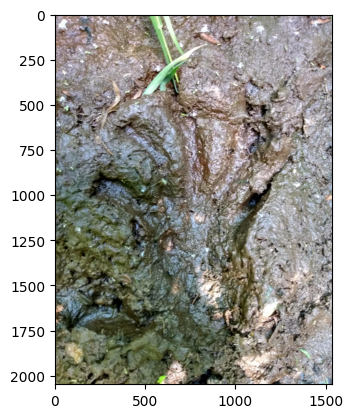

In [38]:
plt.imshow(Image.open("/home/shared/Mammiferes_jpg/Castor/original.jpeg"))

In [39]:
castor = tf.io.read_file("/home/shared/Mammiferes_jpg/Castor/original.jpeg")
castor = tf.image.decode_jpeg(castor, channels=3)
resized_castor = tf.image.resize(castor, [256,256], method="bilinear")

In [40]:
input = tf.expand_dims(
    resized_castor,
    axis = 0
)

In [41]:
input.shape

TensorShape([1, 256, 256, 3])

In [42]:
model.predict(input)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_6" is incompatible with the layer: expected axis -1 of input shape to have value 86528, but received input with shape (1, 115200)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 256, 256, 3), dtype=float32)
  • training=False
  • mask=None

In [43]:
next(iter(test))[0].shape

(8, 224, 224, 3)

In [45]:
class_names = train.classes
print(class_names)

{'Coyote': 0, 'Loup': 1, 'Puma': 2, 'Rat': 3, 'Lapin': 4, 'Ours': 5, 'Castor': 6, 'Lynx': 7, 'Raton_laveur': 8, 'Chien': 9, 'Ecureuil': 10, 'Chat': 11, 'Renard': 12}


In [46]:
plt.figure(figsize=(10, 10))
batch,_ = test.take(3)
plt.imshow(batch[0][1].numpy().astype("uint8"))
plt.title(class_names[batch[1][1]])
plt.axis("off")


AttributeError: 'CustomDataGen' object has no attribute 'take'

<Figure size 1000x1000 with 0 Axes>